## Crosstalk Interface

Here is what I hope to be an enlightening example of how the MMT can be used for crosstalk analysis. The setup below is for 90 and 150 GHz bands for a LAT. The 1728 constitutes about one wafer of multichroic detectors. The main parameter that will need to be changed is the path_to_positions, which is a path to a text file of the focal plane mapped to the sky in degrees. The current wafer_99.txt details the rhombus layout of wafer 99 as output by the instrument model. 

Feel free to email hryciuk@uchicago.edu if you have questions or comments. Thanks!

In [2]:
#path to a text file of detector positions on sky
#it is assumed that this file is in units of degrees so scale appropriately
path_to_positions = '/home/ahryciuk/CMBS4_Noise_Modeling/MapMultiTool/wafer_99.txt'

#frequencies represented in position data in GHz
freqs = [90,150]

num_det = 1728    #number of detectors (1 wafer is ~1722 which includes both 90 GHz and 150 GHz detectors)

#Map Parameters:
#rescale the field of view to ~2/3 of a degree spread in detectors on sky
#This rescales the field of view from a SAT packing density to a LAT packing density as is, but can certainly be changed 
rescale = 50. #(2/3) / 12.5 scales positions.txt to LAT FOV

N = 1024    #number of pixels in horizontal and vertical edges of maps
pixel_size = 0.25 * 1/60.    #size of each pixel in deg

#Main beam fwhm in deg
beam_fwhm = 1.5 * 1/60.

#Correlation Parameters:
freq1 = freqs[0]    #frequency in question
freq2 = freqs[0]    #frequency correlated to freq1
perc_corr = 0.03    #percent at which the signals are correlated
TtoP_suppress = True #suppress the T->P leakage that results from imbalanced detectors along certain polarization angles

#Power Spectrum Binning Parameters:
delta_ell = 50    #bin width
ell_max = 5000    #maximum ell

#Observation Parameters:
scan_sp = 3 #deg/s scan speed
tau_unc = 0.3 #30% uncertainty

#choose normalization of power spectra
## 0 normalizes all PS to 1 for use with biasing spectra
## 'TT', 'EE', 'BB' normalizes to a main spectrum to study leakage
choose_normalization = 'TT'

assert(choose_normalization in [0,'TT','EE','BB'])

#sky decomposition in I, Q, U space
sky_decomp = [1., 0, 0]

The wafer information has a spread of 0.44080578395103986 degrees in x
The wafer information has a spread of 0.5035732643614198 degrees in y
central beam values II:1.0, QQ:1.0, UU:1.0000000000000002
IQ: 0.0
IU: 0.0
QI: 0.0
QU: 1.0627688505977881e-35
UI: 0.0
UQ: 1.9069408023734978e-34


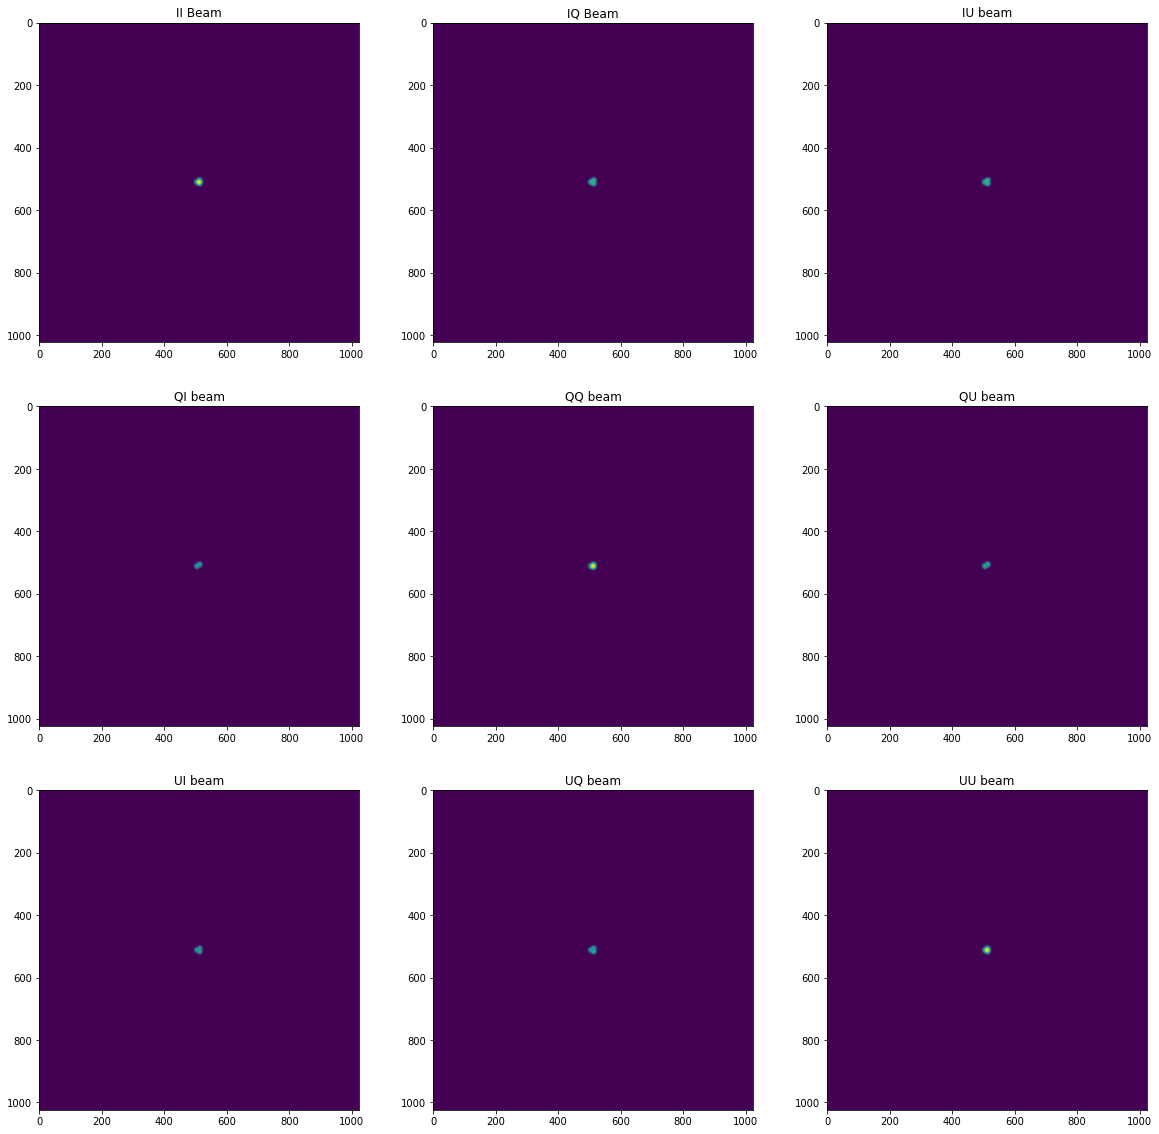

In [3]:
from MMTModules import *
%matplotlib inline
#use above parameters to calculate the beam matrix and display power spectra for a pure T sky


#generate focal plane distribution
det_dict = generate_focal_plane_distribution(path_to_positions, num_det, freqs, rescale)

#generate random coupling
#coupling_matrix = generate_random_coupling(det_dict)
#generate rhombus coupling
coupling_dict = generate_bondpad_coupling_rhombus(det_dict)

#this is inefficient, doing the same calculation twice
unconvolved_beams = calculate_beam_matrix(det_dict, coupling_dict, freq1, freq2, pixel_size, perc_corr, N, TtoP_suppress = False, to_fft=False)

#calculate crosstalk 3x3 IQU beams
convolved_beam_matrix = calculate_crosstalk(det_dict, coupling_dict, [freq1,freq2], pixel_size, perc_corr, N, beam_fwhm, sky_decomp, TtoP_suppress, delta_ell, ell_max, choose_normalization,  unconvolved_beams=unconvolved_beams)


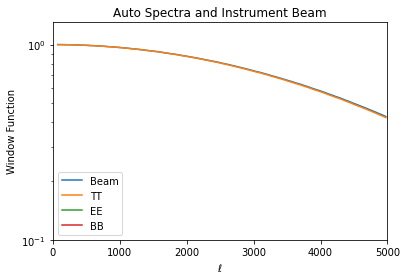

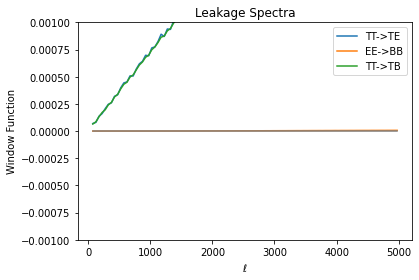

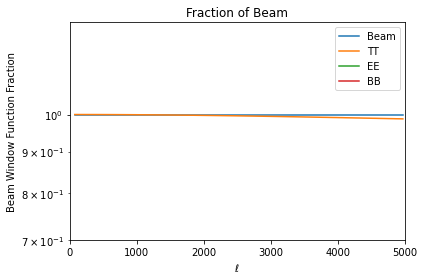

In [4]:
#combine to detector IQU array maps and make 2d FFTs and bin to 1d leakage spectra
binned_ell, binned_spectra = get_leakage_spectra(convolved_beam_matrix, pixel_size, N, beam_fwhm, sky_decomp, delta_ell, ell_max, choose_normalization)

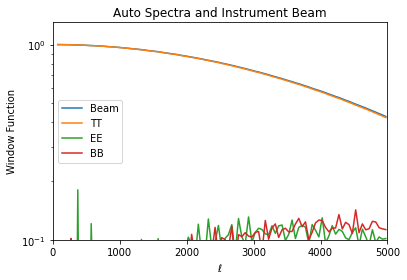

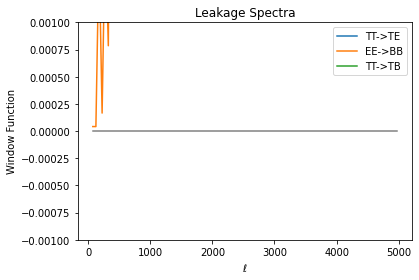

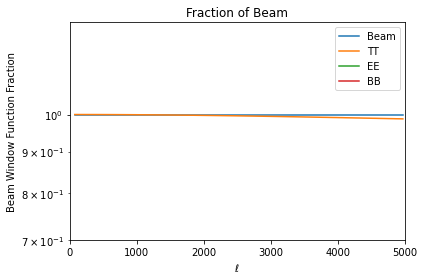

In [5]:
#calculate leakage beams (deproject input maps)
binned_ell, binned_spectra = get_leakage_beams(convolved_beam_matrix, unconvolved_beams, pixel_size, N, beam_fwhm, sky_decomp, delta_ell, ell_max, choose_normalization)

need to put in new normalization for leakages

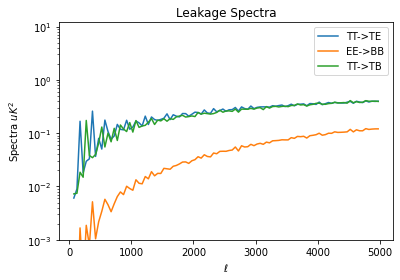

In [6]:
import numpy as np
import matplotlib.pyplot as plt
ell_convert = binned_ell[1:]*(binned_ell[1:] + 1)/(2*np.pi)
plt.semilogy( binned_ell[1:], binned_spectra['TE'])#/(norm_fac*binned_spectra_dict['TT']) )
plt.semilogy(binned_ell[1:], binned_spectra['EB'])#/(norm_fac*binned_spectra_dict['EE']) )
plt.semilogy(binned_ell[1:], binned_spectra['TB'])#/(norm_fac*binned_spectra_dict['TT']))
#plt.semilogy(binned_ell[1:], zero_line, color='gray')
cross_labels = ['TT->TE','EE->BB','TT->TB']
plt.legend(cross_labels)
plt.title('Leakage Spectra')
plt.ylabel('Spectra $uK^2$')
plt.xlabel('$\ell$')
plt.ylim(1e-3,1.2e1)
plt.show()

In order to line up the above transfer functions with the fiducial spectra for parameter estimation, I need to fit the above to a smooth function:

For now I am taking the curve fit weigting to be the standard deviation of the spectrum. To be completely accurate, multiple simulations generating many spectra would need to be taken, but given I took the randomness out of this simulation, this should not matter anymore.

Text(0, 0.5, 'Transfer Function')

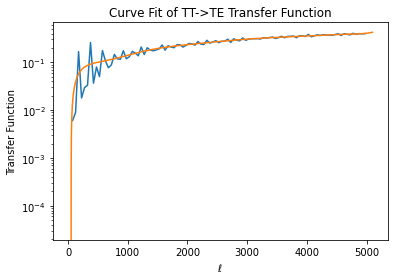

In [7]:
#define 9th order polynomial
def polynomial_9(x, a, b, c, d, e, f, g, h, i, j):
    return a*x**9. + b*x**8. + c*x**7. + d*x**6. + e*x**5. + f*x**4. + g*x**3. + h*x**2. + i*x + j

#For TE
import scipy.optimize as optimization

#ell_set is the range of ell values the binned spectrum goes over
ell_set = binned_ell[1:]
initial_guess = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])

#right now for one simulation just take the std of the dataset. If it's necessary, multiple simulations can be run
#to make the weighting in the optimization more accurate, but for now I don't care as much
sigma = np.sqrt(np.var(binned_spectra['TE']))
errors = sigma*np.ones(len(binned_spectra['TE']))
curve_fit = optimization.curve_fit(polynomial_9, ell_set, binned_spectra['TE'], initial_guess, errors)

parameters = curve_fit[0]
ell = np.arange(ell_max+101)
tf_fit = polynomial_9(ell,parameters[0],parameters[1],parameters[2],
                      parameters[3],parameters[4],parameters[5],
                      parameters[6],parameters[7],parameters[8],parameters[9])
plt.semilogy(binned_ell[1:],binned_spectra['TE'])
plt.semilogy(ell,tf_fit)
plt.title('Curve Fit of TT->TE Transfer Function')
plt.xlabel('$\ell$')
plt.ylabel('Transfer Function')

Zoom in of Rhombus Wafer (The off diagonals are on a magnified scale relative to the on diagonals)

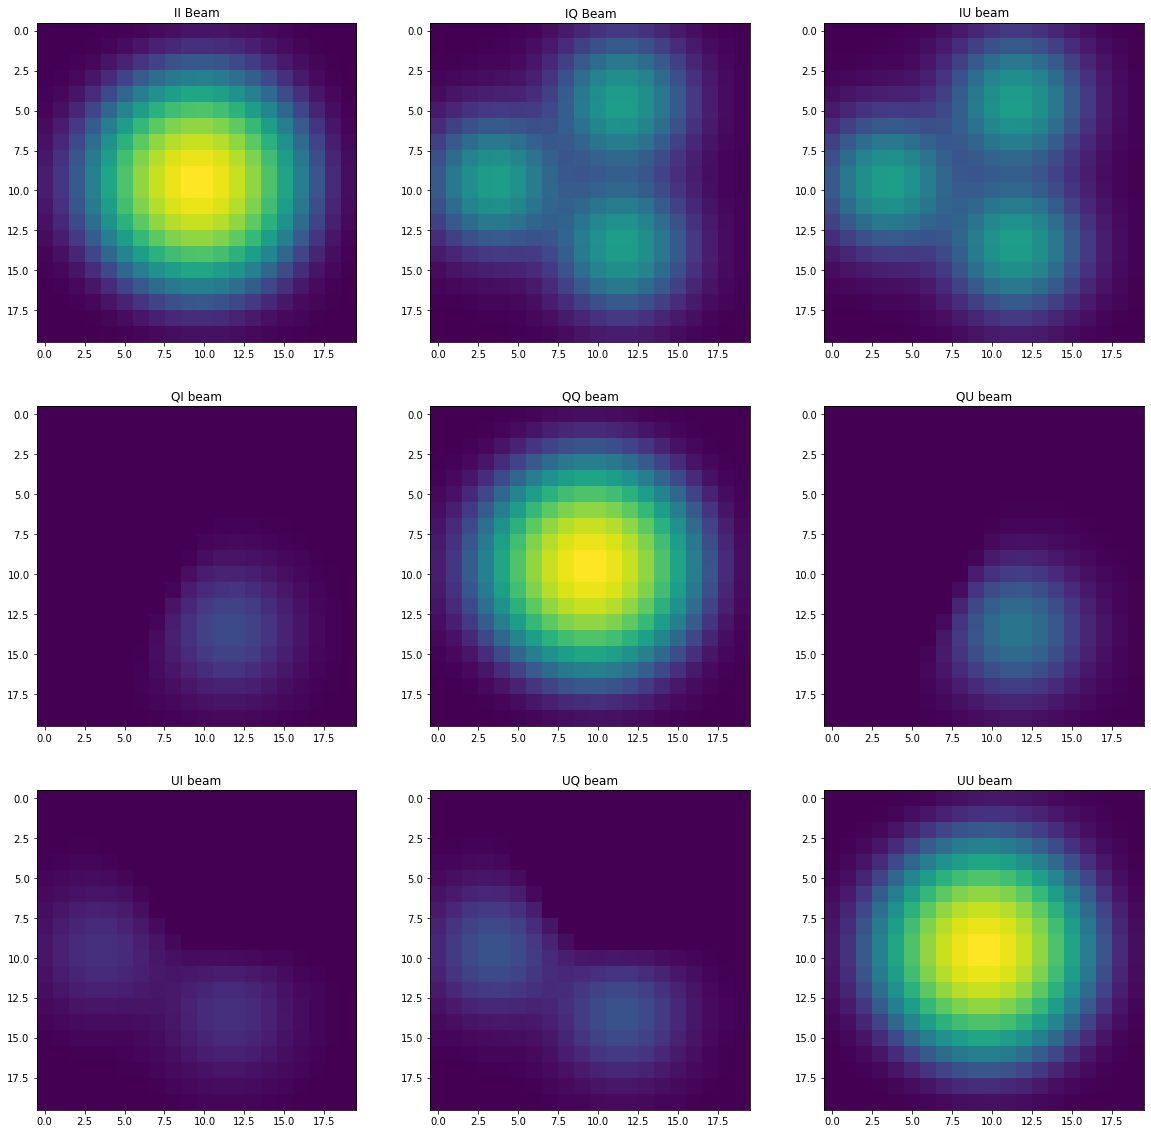

In [18]:
import matplotlib.pyplot as plt
#Plot beam maps in 3x3 matrix
fig, ax = plt.subplots(3,3, figsize=(20,20))
vmin = 10.*np.log(np.min(beam_matrix['II'])+eta)
vmax = 10.*np.log(np.max(beam_matrix['II'])+eta)
eta = 0.0001

#II
ax[0,0].imshow(10*np.log(beam_matrix['II'][502:522,502:522]+eta),vmin=vmin,vmax=vmax)
ax[0,0].set_title('II Beam')

#IQ
ax[0,1].imshow(10.*np.log(beam_matrix['IQ'][502:522,502:522]+eta),vmin=vmin,vmax=10.*np.log(0.02)+vmax)
ax[0,1].set_title('IQ Beam')

#IU
ax[0,2].imshow(10.*np.log(beam_matrix['IU'][502:522,502:522]+eta),vmin=vmin,vmax=10.*np.log(0.02)+vmax)
ax[0,2].set_title('IU beam')

#QI
ax[1,0].imshow(10.*np.log(beam_matrix['QI'][502:522,502:522]+eta),vmin=vmin,vmax=10.*np.log(0.02)+vmax)
ax[1,0].set_title('QI beam')

#QQ
ax[1,1].imshow(10.*np.log(beam_matrix['QQ'][502:522,502:522]+eta),vmin=vmin,vmax=vmax)
ax[1,1].set_title('QQ beam')

#QU
ax[1,2].imshow(10.*np.log(beam_matrix['QU'][502:522,502:522]+eta),vmin=vmin,vmax=10.*np.log(0.02)+vmax)
ax[1,2].set_title('QU beam')

#UI
ax[2,0].imshow(10.*np.log(beam_matrix['UI'][502:522,502:522]+eta),vmin=vmin,vmax=10.*np.log(0.02)+vmax)
ax[2,0].set_title('UI beam')

#UQ
ax[2,1].imshow(10.*np.log(beam_matrix['UQ'][502:522,502:522]+eta),vmin=vmin,vmax=10.*np.log(0.02)+vmax)
ax[2,1].set_title('UQ beam')

#UU
ax[2,2].imshow(10.*np.log(beam_matrix['UU'][502:522,502:522]+eta),vmin=vmin,vmax=vmax)
ax[2,2].set_title('UU beam')
plt.show()

## Detector Time Constant Calibration:

I'm working on finishing the preliminary modules for this. To Be Continued

This first part shows the sampling for the detector time constant distribution. sample_det_tau() samples from a gamma pdf with a maximum bound of 50ms and a mean of k*$\theta$ = 5ms. At the moment, this pdf is not fit to actual data, I'm not sure yet whether fitting the pdf would actually be beneficial. 

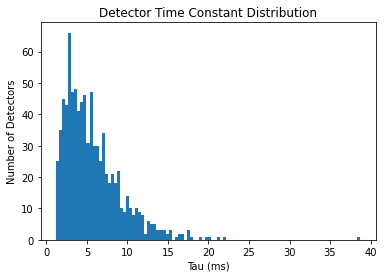

In [7]:
from MMTModules import *
from DetectorTimeConstantModules import *
import numpy as np
import matplotlib.pyplot as plt

#generate focal plane distribution
det_dict = generate_focal_plane_distribution(path_to_positions, num_det, freqs, rescale)

#sample detector time constants after detector dictionary is made
#sampling from a gamma pdf from a max of 50ms and the mean being theta*k = 5ms
sample_det_tau(det_dict, max_x=50, theta=2.5, k=2)

#plot tau samples
tau_list = []
for det in det_dict[freqs[0]].keys():
    tau_list.append(det_dict[freqs[0]][det]['tau'])
    
frequencies = np.histogram(tau_list, bins=100)
bin_width = frequencies[1][1] - frequencies[1][0]
plt.bar(frequencies[1][1:], frequencies[0], width=bin_width)
plt.title('Detector Time Constant Distribution')
plt.xlabel('Tau (ms)')
plt.ylabel('Number of Detectors')
plt.show()

Here is where I define observation parameters that factor into the scanning patterns in fourier space

## Cobaya $N_\nu$ Central Value Shift

Below is as small of an interface as I could make to set up a Cobaya simulation for As,ns, and $N_\nu$. The above calculations could be organized into a dictionary to hand here which will bias the generated fiducial spectra. The simulation approximates the likelihoods as gaussian using TT, TE, and EE spectra. 

When run without a TF, the calculation should return the bias for the gaussian likelihood approximation, which turns out to be 0.00017234468937887826 for $N_\nu$

$$C_\ell^{XY} = C_\ell^{XY} + \delta_\ell^{WV\rightarrow XY} C_\ell^{WV}$$

where $\delta_\ell^{WV\rightarrow XY}$ contains the leakage divided by the instrument beam (This assumes all the instrument beams are the same and the only difference comes from crosstalk.)

Gaussian Likelihood Approximation: $-2ln(L) = (X_c - \tilde{X_c})^T Cov(X_c)^{-1} (X_c - \tilde{X_c})$
for a measured $X_c$ and a model $\tilde{X_c}$

In [3]:
from CobayaModules import *
import numpy as np

#parameters
lmax = 5100    #for accuracy to lmax of 5000
packages_path = '/path/to/your/packages'
ell = np.arange(lmax+1)

#Define transfer functions
#TF_eff_dict = {}
#TF_eff_dict['TE'] = tf_fit[10:]
TF_eff_dict = None

#calculate fiducial spectra
Cl_fid = generate_fiducial(lmax = lmax)

#parameter initialization
As_lower = 1e-9
As_upper = 4e-9
As_fid = 2.2e-9

ns_lower = 0.9
ns_upper = 1.1
ns_fid = 0.96

nnu_lower = 3.04
nnu_upper = 3.05
nnu_fid = 3.046

#define gaussian likelihood
#including TT, TE, EE in likelihood
def my_like_multi_spectra(
        # Parameters that we may sample over (or not)
        Cl_fid=Cl_fid,
        #TF_eff = TF_mag[8:l_max-1],
        TF_eff_dict = TF_eff_dict,
        # Keyword through which the cobaya likelihood instance will be passed.
        _self=None):
    import numpy as np
    
    # Cl of the map: data + noise
    Cl_map = {}
    if TF_eff_dict is not None:
        Cl_map = Cl_fid
        for tf_key in TF_eff_dict.keys():
            if tf_key is 'TT':
                Cl_map['TT'] = TF_eff_dict['TT']*Cl_fid['TT']
            elif tf_key is 'TE':
                Cl_map['TE'] = TF_eff_dict['TE']*Cl_fid['TE']
            elif tf_key is 'EE':
                Cl_map['EE'] = TF_eff_dict['EE']*Cl_fid['EE']
            else:
                print(str(tf_key) + ' spectrum not included')
    else:
        Cl_map = Cl_fid
    
    # Request the Cl from the provider
    # I believe what this is is a snapshot of what the theoretical spectrum is at that particular set of sampled LCDM model
    Cl_theo_tt = _self.provider.get_Cl(ell_factor=False, units="muK2")['tt'][10:lmax+1]
    Cl_theo_ee = _self.provider.get_Cl(ell_factor=False, units="muK2")['ee'][10:lmax+1]
    Cl_theo_te = _self.provider.get_Cl(ell_factor=False, units="muK2")['te'][10:lmax+1]
    
    #Cl_map['TT'] = Cl_theo_tt
    #Cl_map['EE'] = Cl_theo_ee
    #Cl_map['TE'] = Cl_theo_te
    
    Cl_map_theo = {}
    Cl_map_theo['TT'] = Cl_theo_tt
    Cl_map_theo['EE'] = Cl_theo_ee
    Cl_map_theo['TE'] = Cl_theo_te
    
    #covariance matrix is the inverse of the wishart curvature
    Cov_inv = np.asarray( ( (2*ell[8:lmax-1]+1) ) / ( 2*(Cl_map['TT']*Cl_map['EE'] - Cl_map['TE']**2.)**2. ) * [[Cl_map['EE']**2., -2*Cl_map['TE']*Cl_map['EE'], Cl_map['TE']**2.],
       [-2*Cl_map['EE']*Cl_map['TE'], 2*(Cl_map['TT']*Cl_map['EE']+Cl_map['TE']**2.), -2*Cl_map['TT']*Cl_map['TE']],
      [Cl_map['TE']**2., -2*Cl_map['TE']*Cl_map['TT'],Cl_map['TT']**2.]])
    
    #approximating the likelihood as gaussian
    d = np.asarray([Cl_map['TT'], Cl_map['TE'], Cl_map['EE']])
    m = np.asarray([Cl_map_theo['TT'], Cl_map_theo['TE'], Cl_map_theo['EE']])
    #for whatever reason this was not working right with np.matmul but the second one does...
    curv = np.asarray([np.sum(Cov_inv[0,0]*(d-m)[0])+np.sum(Cov_inv[0,1]*(d-m)[1])+np.sum(Cov_inv[0,2]*(d-m)[2]), 
                   np.sum(Cov_inv[1,0]*(d-m)[0])+np.sum(Cov_inv[1,1]*(d-m)[1])+np.sum(Cov_inv[1,2]*(d-m)[2]), 
                   np.sum(Cov_inv[2,0]*(d-m)[0])+np.sum(Cov_inv[2,1]*(d-m)[1])+np.sum(Cov_inv[2,2]*(d-m)[2])])
    
    logp = ( np.matmul(np.transpose(np.sum(d-m,axis=1)), curv) )
            
    # Set our derived parameter
    derived = {'Map_Cl_at_500': Cl_map['TT'][500]}
    return logp, derived

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!


In [6]:


#use above leakage spectra calculation (TE,TB,EB) to bias fiducial spectra
#TF_TE = binned_spectra['TE']
#TF_TB = binned_spectra['TB']
#TF_EB = binned_spectra['EB']

#initialize
#info = initialize_simulation(Nl=None, TF_eff=None, As_lower=1e-9, As_upper=4e-9, As_fid = 2.2e-9, ns_lower=0.9, ns_upper=1.1, ns_fid=0.96, nnu_lower=3.04, nnu_upper=3.05, nnu_fid=3.046)

info = {
        'params': {
            # Fixed
            'ombh2': 0.022, 'omch2': 0.12, 'H0': 68, 'tau': 0.07,
            'mnu': 0.06,
            # Sampled
            'As': {'prior': {'min': As_lower, 'max': As_upper}, 'latex': 'A_s'},
            'ns': {'prior': {'min': ns_lower, 'max': ns_upper}, 'latex': 'n_s'},
            'nnu': {'prior': {'min': nnu_lower, 'max': nnu_upper}, 'latex': 'nnu'},
            # Derived
            'Map_Cl_at_500': {'latex': r'C_{500,\,\mathrm{map}}'}},
        'likelihood': {'my_cl_like': {
            "external": my_like_multi_spectra,
            # Declare required quantities!
            "requires": {'Cl': {'tt': lmax}},
            # Declare derived parameters!
            "output_params": ['Map_Cl_at_500']}},
        'theory': {'camb': {'stop_at_error': True}},
        'packages_path': packages_path}


#calculate
from cobaya.model import get_model
model = get_model(info)


#get shift
num_nnu_samples = 500
nnu_max_shift = calculate_shift(model, nnu_lower, nnu_upper, num_nnu_samples, nnu_fid, As_fid, ns_fid)



[camb] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!
[my_cl_like] Initialized external likelihood.
nnu has been shifted by 0.00017234468937887826 by noise and systematics.
The new maximum liklihood is given by 3.0461723446893787
